In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.ml.regression import GBTRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime

spark = (
    SparkSession.builder.appName("ADS project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/09 22:34:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/09 22:34:27 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/09 22:34:27 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/10/09 22:34:27 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [2]:
sdf = spark.read.parquet('../data/curated/merchant_consumer_abs')
sdf = sdf.drop(*['postcode', 'products', 'take_rate', 'category', 'fraud_group',
                 'user_id', 'consumer', 'consumer_address', 'consumer_state', 'consumer_postcode', 'order_day',
                 '__index_level_0__'])
for i in sdf.columns[:7]:
    if i != "median_age":
        sdf = sdf.drop(i)
# for i in sdf.columns[:4]:
#     sdf = sdf.withColumn(f"log_{i}", when(log(col(i)) > 0, log(col(i))).otherwise(0)).drop(i).withColumnRenamed(f"log_{i}", i)
# sdf = sdf.select(*(sdf.columns[-4:]), *(sdf.columns[:-4]))
sdf

median_age,merchant_name,revenue_level,order_datetime,tag,dollar_value,order_year,order_month,consumer_gender
36.75,Elit Sed Consequa...,a,2022-04-27,artist supply craft,375.16773164703153,2022,4,Female
36.75,Elit Sed Consequa...,a,2022-10-07,artist supply craft,617.8791313462011,2022,10,Male
36.75,Elit Sed Consequa...,a,2022-02-28,artist supply craft,766.5077067424303,2022,2,Female
36.75,Malesuada Vel Ltd,b,2021-07-24,books periodicals...,258.86595899218753,2021,7,Female
36.75,Varius Orci Insti...,a,2021-08-08,tent awning,4.159037931172075,2021,8,Female
36.75,Volutpat Nulla In...,a,2022-10-11,furniture home fu...,8.26105405068297,2022,10,Male
36.75,Mollis Integer Co...,b,2022-05-02,digital goods boo...,83.63154755239155,2022,5,Female
36.75,Elit Sed Consequa...,a,2021-04-08,artist supply craft,87.00495112586256,2021,4,Female
36.75,Eros Limited,c,2021-12-18,digital goods boo...,8.26187754879106,2021,12,Female
36.75,Hendrerit A Corpo...,a,2022-07-14,watch clock jewel...,100.80643267043831,2022,7,Male


In [27]:
graph = pd.read_parquet('../data/curated/merchant_consumer_abs')

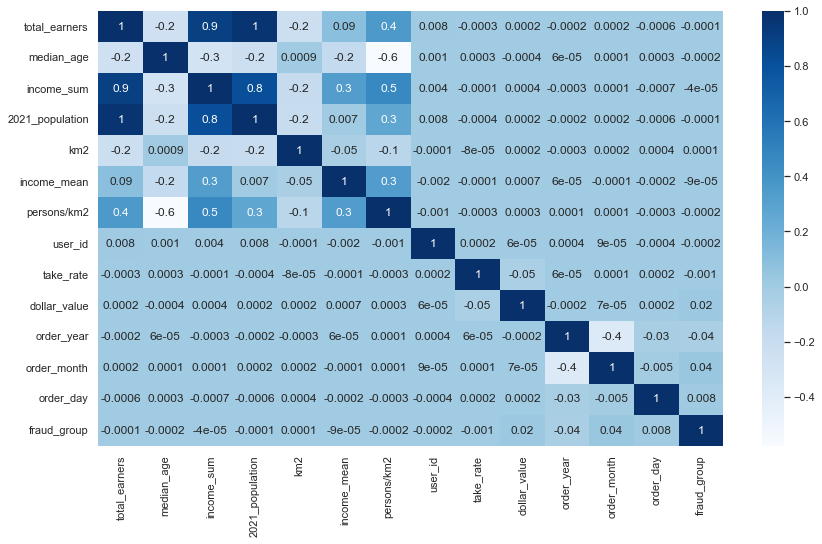

22/10/10 13:52:50 WARN TransportChannelHandler: Exception in connection from dongmensmacbook/192.168.20.8:61094
java.io.IOException: Operation timed out
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:258)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:350)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:722)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:658)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(Ni

In [33]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = graph.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')


In [3]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, Interaction

interact = ["tag", "revenue_level", "order_month", "order_year"]
for i in interact:
    stringIndexer = StringIndexer(inputCol=i, outputCol=f"{i}_num")
    sdf = stringIndexer.fit(sdf).transform(sdf).drop(i)
    encoder = OneHotEncoder(inputCol=f"{i}_num", outputCol=i+"_vec")
    sdf = encoder.fit(sdf).transform(sdf).drop(f"{i}_num")

interaction = Interaction(inputCols=[f"{i}_vec" for i in interact], outputCol="interact")
sdf = interaction.transform(sdf)

In [4]:
genders = sdf.select("consumer_gender").distinct().rdd.flatMap(lambda x: x).collect()
exprs = [when(col("consumer_gender") == category, 1).otherwise(0).alias(category)
         for category in genders]
sdf = sdf.select(*(sdf.columns), *exprs).drop("consumer_gender")

In [5]:
train = sdf.where((col("order_datetime") <= "2022-07-31")).where((col("order_datetime") > "2022-02-28")).drop("order_datetime")
test = sdf.where((col("order_datetime") > "2022-07-31")).drop("order_datetime")

In [6]:
train_agg = train
w = Window.partitionBy('merchant_name')
train_agg = train_agg.withColumn("avg(median_age)", avg("median_age").over(w)).drop("median_age")

In [7]:
agg_cols = train_agg.columns
for i in ["dollar_value", "Female", "Male", "Undisclosed"]:
    agg_cols.remove(i)
train_agg = train_agg.groupBy(agg_cols).agg(sum("dollar_value"), sum("Female"), sum("Male"), sum("Undisclosed"))
w = Window.partitionBy("merchant_name")
for i in ["Female", "Male", "Undisclosed"]:
    train_agg = train_agg.withColumn(f"avg({i.lower()})", avg(f"sum({i})").over(w)).drop(f"sum({i})")
train_agg = train_agg.withColumnRenamed("sum(dollar_value)", "dollar_value")

In [8]:
test_agg = test.groupBy(train_agg.columns[:5]).agg(sum("dollar_value").alias("dollar_value"))
train_agg.columns[5:]
merch_agg = train_agg.select(col("merchant_name").alias("merchant_name_copy"), *(train_agg.columns[5:])).drop("dollar_value").distinct()
test_agg = test_agg.join(merch_agg, test_agg.merchant_name == merch_agg.merchant_name_copy, "left").drop("merchant_name_copy")
test_agg

merchant_name,tag_vec,revenue_level_vec,order_month_vec,order_year_vec,dollar_value,interact,avg(median_age),avg(female),avg(male),avg(undisclosed)
Congue Turpis In LLC,"(24,[18],[1.0])","(4,[0],[1.0])","(11,[0],[1.0])","(1,[0],[1.0])",30614.810375708013,"(1056,[797],[1.0])",45.22752445931588,159.8,167.6,35.2
Congue Turpis In LLC,"(24,[18],[1.0])","(4,[0],[1.0])","(11,[0],[1.0])","(1,[0],[1.0])",30614.810375708013,"(1056,[795],[1.0])",45.22752445931588,159.8,167.6,35.2
Congue Turpis In LLC,"(24,[18],[1.0])","(4,[0],[1.0])","(11,[0],[1.0])","(1,[0],[1.0])",30614.810375708013,"(1056,[798],[1.0])",45.22752445931588,159.8,167.6,35.2
Congue Turpis In LLC,"(24,[18],[1.0])","(4,[0],[1.0])","(11,[0],[1.0])","(1,[0],[1.0])",30614.810375708013,"(1056,[799],[1.0])",45.22752445931588,159.8,167.6,35.2
Congue Turpis In LLC,"(24,[18],[1.0])","(4,[0],[1.0])","(11,[0],[1.0])","(1,[0],[1.0])",30614.810375708013,"(1056,[796],[1.0])",45.22752445931588,159.8,167.6,35.2
Nullam Scelerisqu...,"(24,[13],[1.0])","(4,[0],[1.0])","(11,[2],[1.0])","(1,[0],[1.0])",71192.67870948215,"(1056,[575],[1.0])",45.276285318741714,57.0,58.2,14.2
Nullam Scelerisqu...,"(24,[13],[1.0])","(4,[0],[1.0])","(11,[2],[1.0])","(1,[0],[1.0])",71192.67870948215,"(1056,[579],[1.0])",45.276285318741714,57.0,58.2,14.2
Nullam Scelerisqu...,"(24,[13],[1.0])","(4,[0],[1.0])","(11,[2],[1.0])","(1,[0],[1.0])",71192.67870948215,"(1056,[576],[1.0])",45.276285318741714,57.0,58.2,14.2
Nullam Scelerisqu...,"(24,[13],[1.0])","(4,[0],[1.0])","(11,[2],[1.0])","(1,[0],[1.0])",71192.67870948215,"(1056,[578],[1.0])",45.276285318741714,57.0,58.2,14.2
Nullam Scelerisqu...,"(24,[13],[1.0])","(4,[0],[1.0])","(11,[2],[1.0])","(1,[0],[1.0])",71192.67870948215,"(1056,[577],[1.0])",45.276285318741714,57.0,58.2,14.2


In [9]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

feats = train_agg.columns
feats.remove('merchant_name')
feats.remove('dollar_value')
assembler = VectorAssembler(inputCols=feats, outputCol="features")
train_vec = assembler.transform(train_agg)
test_vec = assembler.transform(test_agg)

In [10]:
from pyspark.ml.regression import LinearRegression

# fit lr model

train_lm = train_vec.select("features", col("dollar_value").alias("label"))
test_lm = train_vec.select("features", col("dollar_value").alias("label"))

lr = LinearRegression()
lm = lr.fit(train_lm)

22/10/09 22:39:38 WARN Instrumentation: [d90bb075] regParam is zero, which might cause numerical instability and overfitting.


22/10/09 22:39:54 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/09 22:39:54 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


22/10/09 22:40:00 WARN TransportClientFactory: DNS resolution succeed for dongmensmacbook/192.168.20.8:61094 took 4568 ms
22/10/09 22:40:00 WARN TransportClientFactory: DNS resolution succeed for dongmensmacbook/192.168.20.8:61094 took 5020 ms
22/10/09 22:40:00 WARN TransportClientFactory: DNS resolution succeed for dongmensmacbook/192.168.20.8:61094 took 5015 ms
22/10/09 22:40:00 WARN TransportClientFactory: DNS resolution succeed for dongmensmacbook/192.168.20.8:61094 took 4470 ms


22/10/09 22:40:01 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
22/10/09 22:40:01 WARN Instrumentation: [d90bb075] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
22/10/09 22:40:03 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/10/09 22:40:03 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [11]:
lm_predict = lm.transform(test_lm)

In [12]:
from pyspark.ml.evaluation import RegressionEvaluator

rmse_evaluator = RegressionEvaluator(labelCol="label",
                                    predictionCol="prediction",
                                    metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="label",
                                   predictionCol="prediction",
                                   metricName="r2")
rmse = rmse_evaluator.evaluate(lm_predict)
print("Root Mean Squared Error (RMSE) = %g" % rmse)
r2 = r2_evaluator.evaluate(lm_predict)
print("R Squared (R2) = %g" % r2)

Root Mean Squared Error (RMSE) = 38616.9


R Squared (R2) = 0.427465


In [13]:
lm_predict

features,label,prediction
"(1100,[6,25,35,39...",2121.3587837887358,6808.205879004589
"(1100,[6,25,31,39...",790.4299265675576,9905.158676493807
"(1100,[6,25,34,39...",1144.9642627052563,7079.539441406234
"(1100,[6,25,33,39...",400.15845996503333,9066.269658201354
"(1100,[6,25,32,39...",669.0063457115391,9127.640921987706
"(1100,[0,25,34,39...",2993.5981770851427,23860.054276780796
"(1100,[0,25,35,39...",2399.3904726601404,24975.795182365437
"(1100,[0,25,31,39...",1622.9228507696537,30503.107474403827
"(1100,[0,25,33,39...",1302.76610253612,27631.11359769864
"(1100,[0,25,32,39...",1439.240784198248,27778.857768431455


In [14]:
from pyspark.ml.regression import DecisionTreeRegressor

DTR = DecisionTreeRegressor(featuresCol="features")
dt = DTR.fit(train_lm)

In [15]:
dt_predict = dt.transform(test_lm)

In [16]:
print("Root Mean Squared Error (RMSE) = %g" % rmse_evaluator.evaluate(dt_predict))
print("R Squared (R2) = %g" % r2_evaluator.evaluate(dt_predict))

Root Mean Squared Error (RMSE) = 31726.7


R Squared (R2) = 0.613546


In [17]:
from pyspark.ml.regression import RandomForestRegressor

RFR = RandomForestRegressor(featuresCol="features")
rf = RFR.fit(train_lm)
rf_predict = rf.transform(test_lm)
print("Root Mean Squared Error (RMSE) = %g" % rmse_evaluator.evaluate(rf_predict))
print("R Squared (R2) = %g" % r2_evaluator.evaluate(rf_predict))

22/10/09 22:50:09 WARN DAGScheduler: Broadcasting large task binary with size 1070.6 KiB


Root Mean Squared Error (RMSE) = 32605


R Squared (R2) = 0.591853


In [18]:
from pyspark.ml.regression import GBTRegressor

GBT = GBTRegressor(featuresCol="features")
gbt = GBT.fit(train_lm)
gbt_predict = gbt.transform(test_lm)
print("Root Mean Squared Error (RMSE) = %g" % rmse_evaluator.evaluate(gbt_predict))
print("R Squared (R2) = %g" % r2_evaluator.evaluate(gbt_predict))

Root Mean Squared Error (RMSE) = 24707.7


R Squared (R2) = 0.765624


In [19]:
gbt_predict = gbt_predict.withColumn("error", col("prediction") - col("label"))
gbt_predict.summary()

summary,label,prediction,error
count,17698,17698,17698
mean,21778.27935955932,21778.279359559332,6.906774094150839...
stddev,51037.39330430412,42257.681345644276,24708.403101262826
min,4.002351071059291,-9179.485618865107,-322065.3863221489
25%,1514.0704157956382,2442.741784247576,-1764.2167048451565
50%,5431.4398469527505,6334.696780688884,672.6408940091815
75%,23928.897852264417,27165.373201936214,3277.620602534287
max,490024.0787984033,482112.49944660673,275914.09190548223


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_real_vs_pred(model_name, y_real, y_pred):
    plt.style.use('ggplot')
    reg_real_vs_pred = pd.concat([y_real, y_pred], axis = 1)
    reg_real_vs_pred = reg_real_vs_pred.head(40)
    reg_real_vs_pred.plot(kind='bar', title='MODEL: '+model_name, figsize=(16,5))
    plt.show()

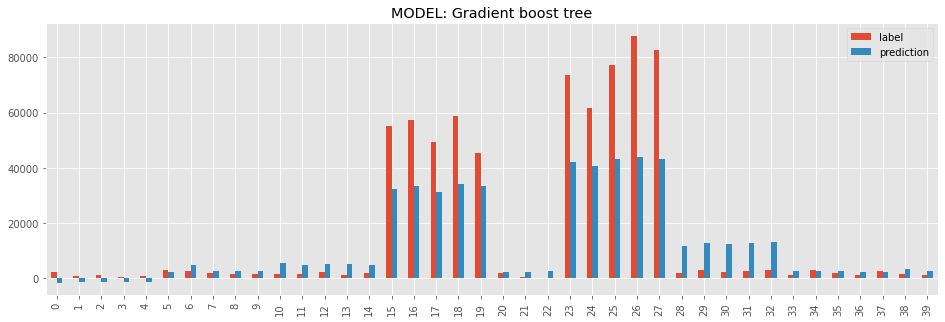

In [21]:
y_true_all = gbt_predict.select("label").toPandas()
y_pred_all = gbt_predict.select("prediction").toPandas()
plot_real_vs_pred("Gradient boost tree", y_true_all, y_pred_all)

In [22]:
gbt_predict.filter(abs(col("error")) <= 100).count()

445

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

tmp = train_agg.toPandas()

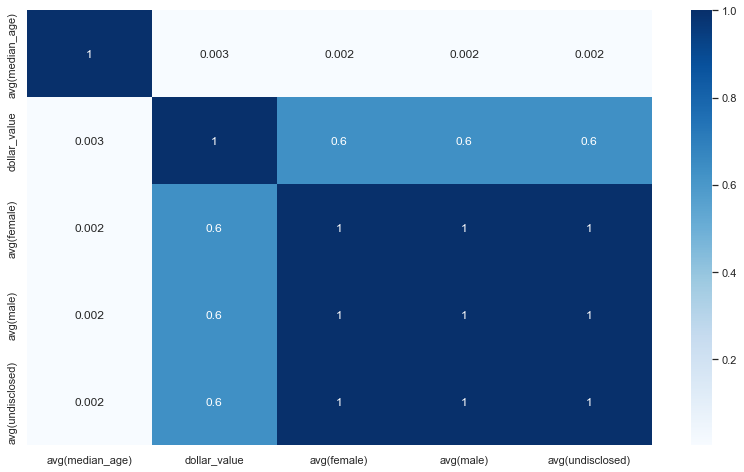

In [25]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = tmp.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

In [26]:
corr.dollar_value

avg(median_age)     0.003398
dollar_value        1.000000
avg(female)         0.630953
avg(male)           0.630904
avg(undisclosed)    0.630430
Name: dollar_value, dtype: float64